# Introduction

Here I'm testing out a DQN agent on the blind cliffwalk example in 

https://arxiv.org/pdf/1511.05952.pdf


Notes to self
1. I'm calculating the TD twice -- I need to optimize this
2. Need to get the hyperparameters from the paper

### Without PER

(episode, score) = (10, 205)
(episode, score) = (20, 37)
(episode, score) = (30, 16)
(episode, score) = (40, 11)
(episode, score) = (50, 36)
(episode, score) = (60, 11)
(episode, score) = (70, 23)
(episode, score) = (80, 41)
(episode, score) = (90, 11)
(episode, score) = (100, 29)


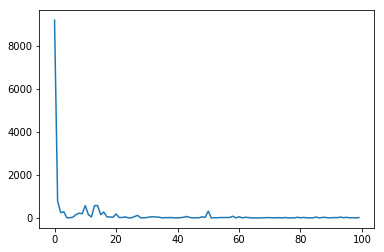

In [5]:
import numpy as np
import matplotlib.pyplot as plt
#from agent_vanilla import Agent
from agent import Agent
from keras.utils import to_categorical
from blind_cliffwalk import Env
%matplotlib inline


#Environment
num_states = 12
env = Env(num_states)
num_states = env.observation_space
num_actions = env.action_space

#Agent
lr,gamma = 0.001, 0.99
agent = Agent(num_states, num_actions, lr, gamma)
agent.C = 1000  #update the target network every K timestesp
agent.epsilon = 0.5
agent.tau = 0.1
decay_factor = 0.99
epsilon_min = 0.01
learning_start = 500


#Train
EPISODES = 100
scores = []
for e in range(1,EPISODES+1):
    state = env.reset()
    state = to_categorical(state,num_states)
    reward_sum = 0
    done = False
    step = 0
    while not done:

        # env.render()
        state = np.reshape(state, [1, num_states])  #reshape for keras
        action = agent.act(state)
        next_state, reward, done, _ = env.step(state[0], action)
        next_state = to_categorical(next_state,num_states)
        reward_sum += reward
        agent.remember(state[0], action, reward, next_state, done)
        state = next_state
        #print state, action

        if agent.buffer.num_memories() > learning_start:
            agent.replay()                       #update the behavior model
            agent.soft_update_target_network()   #update the target model every C timesteps

        #iterate
        step += 1
        if done:
            break

    #Learn & print results
    scores.append(step)
    agent.epsilon = max(agent.epsilon*decay_factor,epsilon_min)
    if e % 10 == 0:
        print '(episode, score) = ' + str((e,step))
plt.plot(scores)

### With PER

(episode, score) = (10, 40)
(episode, score) = (20, 61)
(episode, score) = (30, 15)
(episode, score) = (40, 12)
(episode, score) = (50, 48)
(episode, score) = (60, 58)
(episode, score) = (70, 27)
(episode, score) = (80, 64)
(episode, score) = (90, 33)
(episode, score) = (100, 11)


(0, 200)

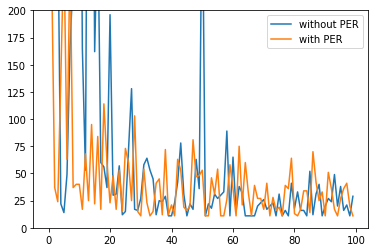

In [6]:
import numpy as np
import matplotlib.pyplot as plt
#from agent_vanilla import Agent
from agent import Agent
from keras.utils import to_categorical
from blind_cliffwalk import Env
%matplotlib inline


#Environment
num_states = 12
env = Env(num_states)
num_states = env.observation_space
num_actions = env.action_space

#Agent
lr,gamma = 0.001, 0.99
agent = Agent(num_states, num_actions, lr, gamma)
agent.C = 1000  #update the target network every K timestesp
agent.epsilon = 0.5
agent.tau = 0.1
decay_factor = 0.99
epsilon_min = 0.01
learning_start = 500


#Train
EPISODES = 100
scores1 = []
for e in range(1,EPISODES+1):
    state = env.reset()
    state = to_categorical(state,num_states)
    reward_sum = 0
    done = False
    step = 0
    while not done:

        # env.render()
        state = np.reshape(state, [1, num_states])  #reshape for keras
        action = agent.act(state)
        next_state, reward, done, _ = env.step(state[0], action)
        next_state = to_categorical(next_state,num_states)
        reward_sum += reward
        agent.remember(state[0], action, reward, next_state, done)
        state = next_state
        #print state, action

        if agent.buffer.num_memories() > learning_start:
            agent.replay(prioritised = True)                       #update the behavior model
            agent.soft_update_target_network()   #update the target model every C timesteps

        #iterate
        step += 1
        if done:
            break

    #Learn & print results
    scores1.append(step)
    agent.epsilon = max(agent.epsilon*decay_factor,epsilon_min)
    if e % 10 == 0:
        print '(episode, score) = ' + str((e,step))
plt.plot(scores)
plt.plot(scores1)
plt.legend(['without PER', 'with PER'])
plt.ylim([0,200])

(0, 200)

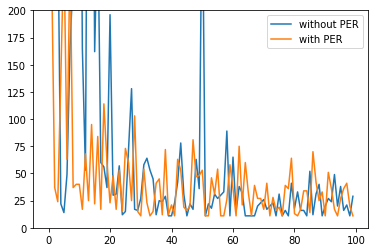

In [7]:
plt.plot(scores)
plt.plot(scores1)
plt.legend(['without PER', 'with PER'])
plt.ylim([0,200])

### Scaling with different $n$

(n, episode, score) = (4, 10, 25)
(n, episode, score) = (4, 20, 47)
(n, episode, score) = (4, 30, 5)
(n, episode, score) = (4, 40, 5)
(n, episode, score) = (6, 10, 10)
(n, episode, score) = (6, 20, 12)
(n, episode, score) = (6, 30, 7)
(n, episode, score) = (6, 40, 5)
(n, episode, score) = (6, 50, 7)
(n, episode, score) = (6, 60, 7)
(n, episode, score) = (6, 70, 5)
(n, episode, score) = (6, 80, 7)
(n, episode, score) = (6, 90, 8)
(n, episode, score) = (6, 100, 5)
(n, episode, score) = (6, 110, 5)
(n, episode, score) = (6, 120, 5)
(n, episode, score) = (6, 130, 5)
(n, episode, score) = (6, 140, 5)
(n, episode, score) = (6, 150, 5)
(n, episode, score) = (7, 10, 27)
(n, episode, score) = (7, 20, 6)
(n, episode, score) = (7, 30, 19)
(n, episode, score) = (7, 40, 15)
(n, episode, score) = (8, 10, 14)
(n, episode, score) = (8, 20, 16)
(n, episode, score) = (8, 30, 10)
(n, episode, score) = (8, 40, 26)
(n, episode, score) = (9, 10, 72)
(n, episode, score) = (9, 20, 8)
(n, episode, score) = (9,

Text(0,0.5,'episodes till solve')

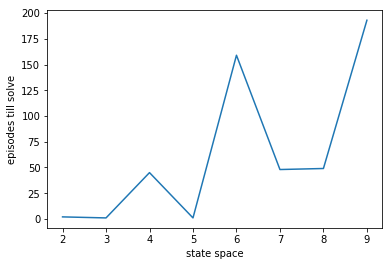

In [53]:
import numpy as np
import matplotlib.pyplot as plt
#from agent_vanilla import Agent
from agent import Agent
from keras.utils import to_categorical
from blind_cliffwalk import Env
%matplotlib inline


res = []
for n in range(2,10):

    #Environment
    num_states = n
    env = Env(num_states)
    num_states = env.observation_space
    num_actions = env.action_space

    #Agent
    lr,gamma = 0.001, 0.99
    agent = Agent(num_states, num_actions, lr, gamma)
    agent.C = 1000  #update the target network every K timestesp
    agent.epsilon = 0.5
    agent.tau = 0.1
    decay_factor = 0.99
    epsilon_min = 0.01
    learning_start = 500


    #Train
    EPISODES = 200
    scores = []
    solved = False
    for e in range(1,EPISODES+1):
        state = env.reset()
        state = to_categorical(state,num_states)
        reward_sum = 0
        done = False
        step = 0
        while not done:

            # env.render()
            state = np.reshape(state, [1, num_states])  #reshape for keras
            action = agent.act(state)
            next_state, reward, done, _ = env.step(state[0], action)
            next_state = to_categorical(next_state,num_states)
            reward_sum += reward
            agent.remember(state[0], action, reward, next_state, done)
            state = next_state
            #print state, action

            if len(agent.memory) > learning_start:
                agent.replay()                       #update the behavior model
                agent.soft_update_target_network()   #update the target model every C timesteps

            #iterate
            step += 1
            if done:
                break

        #Learn & print results
        scores.append(step)
        agent.epsilon = max(agent.epsilon*decay_factor,epsilon_min)
        solved = np.mean(scores[e-50:e]) < 1.1*num_states
        if e % 10 == 0:
            print '(n, episode, score) = ' + str((n, e,step))
        if solved == True:
            break

    #np.savetxt('stats/scores_blind_cliffwalk.txt',scores)
    res.append([n,e])
    
res = np.array(res)
plt.plot(res[:,0],res[:,1])
plt.xlabel('state space')
plt.ylabel('episodes till solve')

### Watch a smart agent

Ok, it's not PERFECTLY the same. But still pretty good.

### Roughwork